# MG dataset

Comparison of different inducing point GP-regression methods.

In [1]:
import sys
sys.path.append('/Users/IzmailovPavel/Documents/Education/Course Project/Code')
import numpy as np
import matplotlib as mpl

from matplotlib import pyplot as plt

from GP.covariance_functions import SquaredExponential
from GP.gaussian_process_regression import GPR

from sklearn.cluster import KMeans

from sklearn.datasets import load_svmlight_file
from sklearn.preprocessing import StandardScaler
from sklearn.utils import shuffle
from sklearn.svm import SVR
from sklearn.metrics import r2_score
%matplotlib inline
%load_ext autoreload
%autoreload 2

Loading the data

In [2]:
x_tr, y_tr = load_svmlight_file('../../../../Programming/DataSets/Regression/mg(1385, 6).txt')
x_tr, y_tr = shuffle(x_tr, y_tr, random_state=241)
data_name = 'mg'
file_name = data_name

x_tr = x_tr.toarray().T
scaler_x = StandardScaler()
scaler_y = StandardScaler()

y_tr = y_tr.reshape((y_tr.size, 1))
x_test = x_tr[:, int(x_tr.shape[1] * 0.8):]
y_test = y_tr[int(x_tr.shape[1] * 0.8):, :]
y_tr = y_tr[:int(x_tr.shape[1] * 0.8), :]
x_tr = x_tr[:, : int(x_tr.shape[1] * 0.8)]


x_tr = scaler_x.fit_transform(x_tr.T).T
x_test = scaler_x.transform(x_test.T).T
y_tr = scaler_y.fit_transform(y_tr)
y_test = scaler_y.transform(y_test)


dim, num = x_tr.shape
print('of objects:', num)
print('of features', dim)
print(data_name)

of objects: 1108
of features 6
mg


## SVM
We train an SVM with RBF kernel for reference.

In [3]:
svm = SVR(C=5e-1)
svm.fit(x_tr.T, y_tr[:, 0])
pred = svm.predict(x_test.T)
r2_score(y_test, pred)

0.74057253616984964

# K-means cluster centers as inducing inputs

We use K-means cluster centers as inducing point positions and don't optimize wrt them.

In [4]:
ind_num = 100
print('Finding means...')
means = KMeans(n_clusters=ind_num, n_init=3, max_iter=100, random_state=241)
means.fit(x_tr.T)
inputs = means.cluster_centers_.T
print('...found')

Finding means...
...found


In [5]:
cov_params = np.array([1.0, 5., 1.0])

# SVI-L-BFGS-B

L-BFGS-B optimization method applied to the svi objective (see the text).

In [5]:
model_covariance_obj = SquaredExponential(np.copy(cov_params))
lbfgs_svi_gp = GPR(model_covariance_obj, method='svi', parametrization='cholesky', optimizer='L-BFGS-B')

In [6]:
opts = {'maxiter': 50, 'mydisp': True}
lbfgs_svi_res = lbfgs_svi_gp.fit(x_tr, y_tr, num_inputs=ind_num, optimizer_options=opts, inputs=inputs)

/Users/IzmailovPavel/Documents/Education/Course Project/Code/GP/optimization.py:369: OptimizeWarning: Unknown solver options: mydisp
  out = op.minimize(func, x0, jac=jac, callback=callback, **kwargs)


In [8]:
metric = lambda w: lbfgs_svi_gp.get_prediction_quality(w, x_test, y_test)
lbfgs_svi_x_lst, lbfgs_svi_y_lst = lbfgs_svi_res.plot_performance(metric, 'i', freq=1)

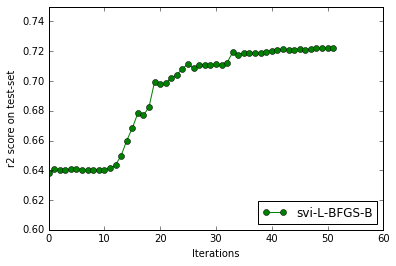

In [9]:
plt.plot(lbfgs_svi_x_lst, lbfgs_svi_y_lst, '-go', label='svi-L-BFGS-B')
plt.ylim([.6, .75])
plt.legend(loc=4)
plt.xlabel('Iterations')
plt.ylabel('r2 score on test-set')

In [10]:
np.save('../plots/regression_revision/mg/'+ data_name +'_lbfgs_svi_x.npy', lbfgs_svi_x_lst)
np.save('../plots/regression_revision/mg/'+ data_name +'_lbfgs_svi_y.npy', lbfgs_svi_y_lst)

## VI
L-BFGS-B optimization method applied to the vi objective (see the text).

In [11]:
model_covariance_obj = SquaredExponential(np.copy(cov_params))
vi_gp = GPR(model_covariance_obj, method='means', optimizer='L-BFGS-B')

In [12]:
opts = {'maxiter': 20, 'disp': True}
vi_res = vi_gp.fit(x_tr, y_tr, num_inputs=ind_num, optimizer_options=opts, inputs=inputs)

In [13]:
metric = lambda w: vi_gp.get_prediction_quality(w, x_tr, y_tr, x_test, y_test)
vi_x_lst, vi_y_lst = vi_res.plot_performance(metric, 'i', freq=1)

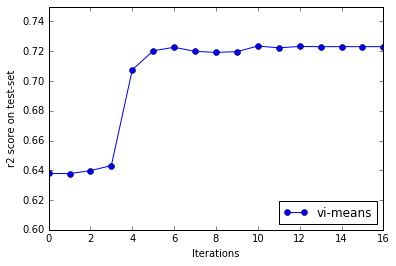

In [14]:
plt.plot(vi_x_lst, vi_y_lst, '-bo', label='vi-means')
plt.ylim([.6, .75])
plt.legend(loc=4)
plt.xlabel('Iterations')
plt.ylabel('r2 score on test-set')

In [26]:
vi_y_lst[-1]

0.7230731516494695

In [27]:
np.save('../plots/regression_revision/mg/'+ data_name +'_vi_x.npy', vi_x_lst)
np.save('../plots/regression_revision/mg/'+ data_name +'_vi_y.npy', vi_y_lst)

## Stochastic SVI
Stochastic (incremental) optimization methods applied to the svi objective (see the text).
### AdaDelta-Cholesky
Adadelta method from climin library.

In [16]:
model_covariance_obj = SquaredExponential(np.copy(cov_params))
ad_svi_gp = GPR(model_covariance_obj, method='svi', parametrization='cholesky', optimizer='AdaDelta')

In [17]:
opts = {'mydisp': True, 'print_freq': 50, 'step_rate': 1.,
                'maxiter': 300, 'batch_size':200}
ad_svi_res = ad_svi_gp.fit(x_tr, y_tr, num_inputs=ind_num, optimizer_options=opts, inputs=inputs)

Iteration  50 :
	Gradient norm 0.318889659778
Iteration  100 :
	Gradient norm 0.241628333399
Iteration  150 :
	Gradient norm 0.182784687757
Iteration  200 :
	Gradient norm 0.179054090833
Iteration  250 :
	Gradient norm 0.137627133089
Iteration  300 :
	Gradient norm 0.262065620107


In [21]:
metric = lambda w: ad_svi_gp.get_prediction_quality(w, x_test, y_test)
ad_svi_x_lst, ad_svi_y_lst = ad_svi_res.plot_performance(metric, 'i', freq=5)

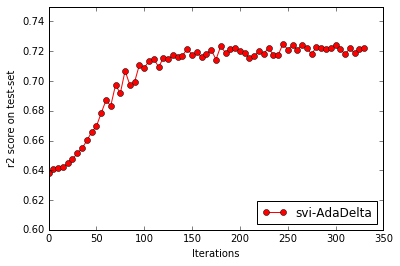

In [22]:
plt.plot(ad_svi_x_lst, ad_svi_y_lst, '-ro', label='svi-AdaDelta')
plt.ylim([.6, .75])
plt.legend(loc=4)
plt.xlabel('Iterations')
plt.ylabel('r2 score on test-set')

In [23]:
ad_svi_y_lst[-1]

0.72243899142010704

In [28]:
np.save('../plots/regression_revision/mg/'+ data_name +'_ad_svi_x.npy', ad_svi_x_lst)
np.save('../plots/regression_revision/mg/'+ data_name +'_ad_svi_y.npy', ad_svi_y_lst)

###SG-cholesky
Stochastic gradient descent.

In [50]:
model_covariance_obj = SquaredExponential(np.copy(cov_params))
sg_svi_gp = GPR(model_covariance_obj, method='svi', parametrization='cholesky', optimizer='SG')

In [51]:
opts = {'maxiter':350, 'batch_size': 200 , 'print_freq': 50, 'step0': 9e-1, 'gamma': .2}
sg_svi_res = sg_svi_gp.fit(x_tr, y_tr, num_inputs=ind_num, optimizer_options=opts, inputs=inputs)

Epoch  0 :
	Step: 0.9
	Parameters [ 0.93607452  4.99467501]
Epoch  50 :
	Step: 0.411574546735
	Parameters [ 0.77027713  4.30147237]
Epoch  100 :
	Step: 0.358296453498
	Parameters [ 0.74677996  3.38752211]
Epoch  150 :
	Step: 0.330387994426
	Parameters [ 0.547927    2.50578272]
Epoch  200 :
	Step: 0.31191517942
	Parameters [ 0.51191089  2.12875498]
Epoch  250 :
	Step: 0.298300861561
	Parameters [ 0.47742466  2.08897393]
Epoch  300 :
	Step: 0.287619454654
	Parameters [ 0.48513934  2.01026677]


In [52]:
metric = lambda w: sg_svi_gp.get_prediction_quality(w, x_test, y_test)
sg_svi_x_lst, sg_svi_y_lst = sg_svi_res.plot_performance(metric, 'i', freq=5)

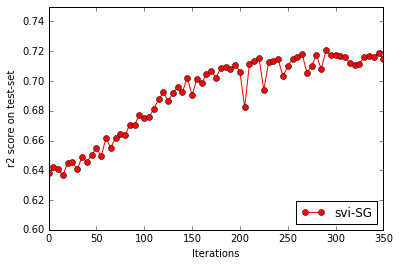

In [53]:
plt.plot(sg_svi_x_lst, sg_svi_y_lst, '-ro', label='svi-SG')
plt.ylim([.6, .75])
plt.legend(loc=4)
plt.xlabel('Iterations')
plt.ylabel('r2 score on test-set')

In [54]:
sg_svi_y_lst[-1]

0.72243899142010704

In [62]:
np.save('../plots/regression_revision/mg/'+ data_name +'_sg_svi_x.npy', sg_svi_x_lst)
np.save('../plots/regression_revision/mg/'+ data_name +'_sg_svi_y.npy', sg_svi_y_lst)

### SG-Natural
Stochastic gradient descent with natural gradients with respect to the variational parameters.

In [5]:
model_covariance_obj = SquaredExponential(np.copy(cov_params))
sng_svi_gp = GPR(model_covariance_obj, method='svi', parametrization='natural')

In [6]:
opts = {'maxiter':1000, 'batch_size': 300 , 'print_freq': 50, 'step0': 1., 'gamma': 0.2}
sng_svi_res = sng_svi_gp.fit(x_tr, y_tr, num_inputs=ind_num, optimizer_options=opts, inputs=inputs)

Epoch  0 :
	Step: 1.0
	Parameters [ 0.91165161  5.00644796]
Epoch  50 :
	Step: 0.457305051927
	Parameters [ 0.78975459  4.59049934]
Epoch  100 :
	Step: 0.398107170553
	Parameters [ 0.69403802  4.07710014]
Epoch  150 :
	Step: 0.367097771585
	Parameters [ 0.63201589  3.43030459]
Epoch  200 :
	Step: 0.346572421578
	Parameters [ 0.52517491  2.76214506]
Epoch  250 :
	Step: 0.331445401734
	Parameters [ 0.45067977  2.31362412]
Epoch  300 :
	Step: 0.319577171838
	Parameters [ 0.47622396  2.20126248]
Epoch  350 :
	Step: 0.309874893939
	Parameters [ 0.43762054  2.17138648]
Epoch  400 :
	Step: 0.301708816827
	Parameters [ 0.49007303  2.10860289]
Epoch  450 :
	Step: 0.294684638481
	Parameters [ 0.44315544  2.06131589]
Epoch  500 :
	Step: 0.288539981181
	Parameters [ 0.45024158  2.04163324]
Epoch  550 :
	Step: 0.283091912294
	Parameters [ 0.49522669  2.00647345]
Epoch  600 :
	Step: 0.27820808696
	Parameters [ 0.43461472  2.02573937]
Epoch  650 :
	Step: 0.273789840442
	Parameters [ 0.44709421  2.033

In [7]:
metric = lambda w: sng_svi_gp.get_prediction_quality(w, x_test, y_test)
sng_svi_x_lst, sng_svi_y_lst = sng_svi_res.plot_performance(metric, 'i', freq=10)

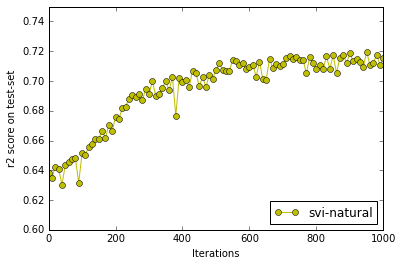

In [8]:
plt.plot(sng_svi_x_lst, sng_svi_y_lst, '-yo', label='svi-natural')
plt.ylim([.6, .75])
plt.legend(loc=4)
plt.xlabel('Iterations')
plt.ylabel('r2 score on test-set')

In [10]:
sng_svi_y_lst[-1]

0.71536557341226747

In [11]:
np.max(sng_svi_y_lst)

0.71967830932321486

In [12]:
np.save('../plots/regression_revision/mg/'+ data_name +'_sng_svi_x.npy', sng_svi_x_lst)
np.save('../plots/regression_revision/mg/'+ data_name +'_sng_svi_y.npy', sng_svi_y_lst)

### CliminSG-Natural

In [103]:
model_covariance_obj = SquaredExponential(np.copy(cov_params))
sng_svi_gp = GPR(model_covariance_obj, method='svi', parametrization='natural', optimizer='climinSG')

In [104]:
opts = {'mydisp': True, 'print_freq': 50, 'step_rate': 3e-1,
                'maxiter': 1000, 'batch_size': 300 }
sng_svi_res = sng_svi_gp.fit(x_tr, y_tr, num_inputs=ind_num, optimizer_options=opts, inputs=inputs)

Using SG optimizer
Iteration  49 :
	Gradient norm 0.149908007574
Iteration  99 :
	Gradient norm 0.0654812519667
Iteration  149 :
	Gradient norm 0.360225973413
Iteration  199 :
	Gradient norm 0.0970290819474
Iteration  249 :
	Gradient norm 0.0890386773958
Iteration  298 :
	Gradient norm 0.283815006953
Iteration  348 :
	Gradient norm 0.123503594917
Iteration  398 :
	Gradient norm 0.397674795209
Iteration  448 :
	Gradient norm 0.261698309459
Iteration  498 :
	Gradient norm 0.272728228746
Iteration  548 :
	Gradient norm 0.159842478148
Iteration  597 :
	Gradient norm 0.444490812047
Iteration  647 :
	Gradient norm 0.176507266489
Iteration  697 :
	Gradient norm 0.269465544295
Iteration  747 :
	Gradient norm 0.33462374751
Iteration  797 :
	Gradient norm 0.460831099097
Iteration  846 :
	Gradient norm 0.0743889842655
Iteration  896 :
	Gradient norm 0.417286247665
Iteration  946 :
	Gradient norm 0.177919282466
Iteration  996 :
	Gradient norm 0.372185877634


In [105]:
metric = lambda w: sng_svi_gp.get_prediction_quality(w, x_test, y_test)
sng_svi_x_lst, sng_svi_y_lst = sng_svi_res.plot_performance(metric, 'i', freq=10)

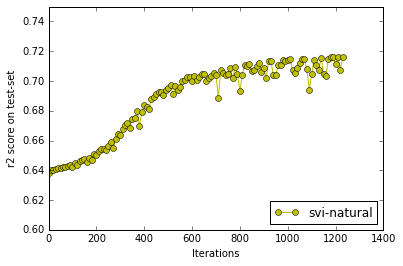

In [106]:
plt.plot(sng_svi_x_lst, sng_svi_y_lst, '-yo', label='svi-natural')
plt.ylim([.6, .75])
plt.legend(loc=4)
plt.xlabel('Iterations')
plt.ylabel('r2 score on test-set')

as we can see the problem is not about my implementation of sgd.

### SG-Natural-ss
This method uses natural gradients for svi wrt variational parameters as svi-natural does. But this method chooses separate step-length for the to types of parameters it optimizes.

In [108]:
model_covariance_obj = SquaredExponential(np.copy(cov_params))
ss_sng_svi_gp = GPR(model_covariance_obj, method='svi', parametrization='natural', optimizer='climinSG')

In [109]:
opts = {'mydisp': True, 'print_freq': 50, 'step_rate': .4,
                'maxiter': 500, 'batch_size': 300, 'nat_mult': 6.}
ss_sng_svi_res = ss_sng_svi_gp.fit(x_tr, y_tr, num_inputs=ind_num, optimizer_options=opts, inputs=inputs)

6.0
Using SG optimizer
Iteration  49 :
	Gradient norm 0.461194613137
Iteration  99 :
	Gradient norm 0.572049385082
Iteration  149 :
	Gradient norm 0.509330767005
Iteration  199 :
	Gradient norm 0.34443677774
Iteration  249 :
	Gradient norm 0.335735876355
Iteration  298 :
	Gradient norm 0.784407144336
Iteration  348 :
	Gradient norm 0.339012363417
Iteration  398 :
	Gradient norm 0.457218056751
Iteration  448 :
	Gradient norm 0.4351783604
Iteration  498 :
	Gradient norm 0.524961013292


In [110]:
metric = lambda w: ss_sng_svi_gp.get_prediction_quality(w, x_test, y_test)
ss_sng_svi_x_lst, ss_sng_svi_y_lst = ss_sng_svi_res.plot_performance(metric, 'i', freq=10)

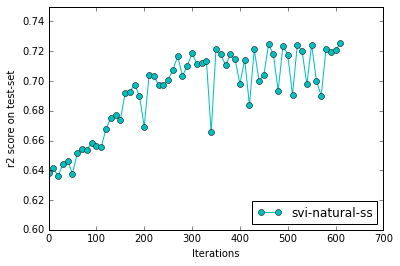

In [111]:
plt.plot(ss_sng_svi_x_lst, ss_sng_svi_y_lst, '-co', label='svi-natural-ss')
plt.ylim([.6, .75])
plt.legend(loc=4)
plt.xlabel('Iterations')
plt.ylabel('r2 score on test-set')

In [112]:
np.save('../plots/regression_revision/mg/'+ data_name +'_ss_sng_svi_x.npy', ss_sng_svi_x_lst)
np.save('../plots/regression_revision/mg/'+ data_name +'_ss_sng_svi_y.npy', ss_sng_svi_y_lst)

# Stochastic methods

In [90]:
ad_svi_x_lst = np.load('../plots/regression_revision/mg/'+ data_name +'_ad_svi_x.npy')
ad_svi_y_lst = np.load('../plots/regression_revision/mg/'+ data_name +'_ad_svi_y.npy')
sng_svi_x_lst = np.load('../plots/regression_revision/mg/'+ data_name +'_sng_svi_x.npy')
sng_svi_y_lst = np.load('../plots/regression_revision/mg/'+ data_name +'_sng_svi_y.npy')
sg_svi_x_lst = np.load('../plots/regression_revision/mg/'+ data_name +'_sg_svi_x.npy')
sg_svi_y_lst = np.load('../plots/regression_revision/mg/'+ data_name +'_sg_svi_y.npy')
ss_sng_svi_x_lst = np.load('../plots/regression_revision/mg/'+ data_name +'_ss_sng_svi_x.npy')
ss_sng_svi_y_lst = np.load('../plots/regression_revision/mg/'+ data_name +'_ss_sng_svi_y.npy')

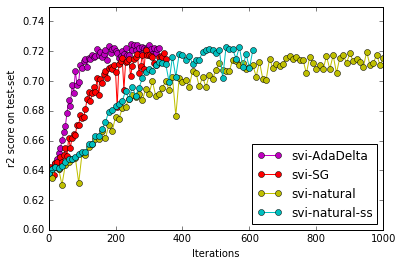

In [91]:
plt.plot(ad_svi_x_lst, ad_svi_y_lst, '-mo', label='svi-AdaDelta')
plt.plot(sg_svi_x_lst, sg_svi_y_lst, '-ro', label='svi-SG')
plt.plot(sng_svi_x_lst, sng_svi_y_lst, '-yo', label='svi-natural')
plt.plot(ss_sng_svi_x_lst, ss_sng_svi_y_lst, '-co', label='svi-natural-ss')
plt.ylim([.6, .75])
plt.legend(loc=4)
plt.xlabel('Iterations')
plt.ylabel('r2 score on test-set')